In [19]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Classifying
Here we just concat the processed text to have different option to test

In [20]:
df = pd.read_json("dataframe.json")
df['processed_text_only'] = df['processed_text'].apply(lambda x: " ".join(x[1]))
df['processed_desc_only'] = df['processed_desc'].apply(lambda x: " ".join(x[1]) if x else "")
df['annotated_text_only'] = df['processed_text'].apply(lambda x: " ".join([f"{z}({y})" for z, y in x[0]]))
df['annotated_desc_only'] = df['processed_desc'].apply(lambda x: " ".join([f"{z}({y})" for z, y in x[0]] if x else ""))
df['processed_all'] = df[["processed_text_only", "processed_desc_only"]].apply(" ".join, axis=1)
df['annotated_all'] = df[["annotated_text_only", "annotated_desc_only"]].apply(" ".join, axis=1)
df['all'] = df[["annotated_all", "processed_all"]].apply(" ".join, axis=1)
df.head()

,person,text,processed_text,desc,processed_desc,cat,base,processed_text_only,processed_desc_only,annotated_text_only,annotated_desc_only,processed_all,annotated_all,all
0,Mittarfik Nerlerit Inaat,Nerlerit Inaat Airport (Greenlandic: Mittarfik...,"[[[nerlerit, JJ], [inaat, NN], [airport, NN], ...","airport in Sermersooq, Greenland","[[[airport, NN], [sermersooq, NN], [greenland,...",Airports,Q3049018,nerlerit inaat airport greenland mittarfik ner...,airport sermersooq greenland,nerlerit(JJ) inaat(NN) airport(NN) greenland(N...,airport(NN) sermersooq(NN) greenland(NN),nerlerit inaat airport greenland mittarfik ner...,nerlerit(JJ) inaat(NN) airport(NN) greenland(N...,nerlerit(JJ) inaat(NN) airport(NN) greenland(N...
1,Nerlerit Inaat Lufthavn,Nerlerit Inaat Airport (Greenlandic: Mittarfik...,"[[[nerlerit, JJ], [inaat, NN], [airport, NN], ...","airport in Sermersooq, Greenland","[[[airport, NN], [sermersooq, NN], [greenland,...",Airports,Q3049018,nerlerit inaat airport greenland mittarfik ner...,airport sermersooq greenland,nerlerit(JJ) inaat(NN) airport(NN) greenland(N...,airport(NN) sermersooq(NN) greenland(NN),nerlerit inaat airport greenland mittarfik ner...,nerlerit(JJ) inaat(NN) airport(NN) greenland(N...,nerlerit(JJ) inaat(NN) airport(NN) greenland(N...
2,Constable Pynt Lufthavn,Nerlerit Inaat Airport (Greenlandic: Mittarfik...,"[[[nerlerit, JJ], [inaat, NN], [airport, NN], ...","airport in Sermersooq, Greenland","[[[airport, NN], [sermersooq, NN], [greenland,...",Airports,Q3049018,nerlerit inaat airport greenland mittarfik ner...,airport sermersooq greenland,nerlerit(JJ) inaat(NN) airport(NN) greenland(N...,airport(NN) sermersooq(NN) greenland(NN),nerlerit inaat airport greenland mittarfik ner...,nerlerit(JJ) inaat(NN) airport(NN) greenland(N...,nerlerit(JJ) inaat(NN) airport(NN) greenland(N...
3,Nerlerit Inaat Airport,Nerlerit Inaat Airport (Greenlandic: Mittarfik...,"[[[nerlerit, JJ], [inaat, NN], [airport, NN], ...","airport in Sermersooq, Greenland","[[[airport, NN], [sermersooq, NN], [greenland,...",Airports,Q3049018,nerlerit inaat airport greenland mittarfik ner...,airport sermersooq greenland,nerlerit(JJ) inaat(NN) airport(NN) greenland(N...,airport(NN) sermersooq(NN) greenland(NN),nerlerit inaat airport greenland mittarfik ner...,nerlerit(JJ) inaat(NN) airport(NN) greenland(N...,nerlerit(JJ) inaat(NN) airport(NN) greenland(N...
4,Red Dog Airport,"Red Dog Airport (IATA: RDB, ICAO: PADG, FAA LI...","[[[red, JJ], [dog, NN], [airport, NN], [iata, ...","airport in Alaska, United States of America","[[[airport, NN], [alaska, NNS], [unit, NN], [s...",Airports,Q4392064,red dog airport iata rdb icao padg faa lid dgg...,airport alaska unit state america,red(JJ) dog(NN) airport(NN) iata(NN) rdb(NN) i...,airport(NN) alaska(NNS) unit(NN) state(NN) ame...,red dog airport iata rdb icao padg faa lid dgg...,red(JJ) dog(NN) airport(NN) iata(NN) rdb(NN) i...,red(JJ) dog(NN) airport(NN) iata(NN) rdb(NN) i...


In [21]:
# This method will return the test categories and prediction
def compute(df, x="processed_all", y='cat', max_iter=15):
    X = df[x]
    Y = df[y]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42) # Split the data
    tfidf_vectorizer = TfidfVectorizer(max_features=8000,
                                       use_idf=True,
                                       stop_words='english',
                                       tokenizer=nltk.word_tokenize,
                                       ngram_range=(1, 3))
    #transform  the dataset
    X_train_vec = tfidf_vectorizer.fit_transform(X_train)
    X_test_vec = tfidf_vectorizer.transform(X_test)
    # Create a Perceptron object
    classifier = Perceptron(max_iter=max_iter)
    # Train the model on the training data
    classifier.fit(X_train_vec, Y_train)
    # Test the model on the test data
    Y_pred = classifier.predict(X_test_vec)
    return Y_test, Y_pred

# This method return all the stats we need for a given test category and prediction
def stats(Y_test, Y_pred):
    # Calculate the precision,recall and fscore form metrics library
    prec, rec, f1, _ = precision_recall_fscore_support(
        Y_test,
        Y_pred,
        average="macro",
        zero_division=0
    )
    # We create 2 confusion_matrix here
    # First one has the name of the categories as the header of the cm
    cm = pd.crosstab(Y_test, Y_pred)
    # Second one has index of the categories as the header of the cm
    conf = confusion_matrix(Y_test, Y_pred)
    cat_acc = {}
    # We use the second one for calculating the accuracy per categories
    for idx, cls in enumerate(set(Y_test)):
        tn = np.sum(np.delete(np.delete(conf, idx, axis=0), idx, axis=1)) # get the true negatives
        tp = conf[idx, idx] # Get true positives
        cat_acc[cls] = (tp + tn) / np.sum(conf) # Calculate the accuracy

    return {"precision": prec, "recall": rec, "f1_score": f1, "accuracy": accuracy_score(Y_test, Y_pred),
            "confusion_matrix": cm, "category_accuracy": cat_acc}

# This method is here to visualize the heatmap of the confusion matrix  and to output the statistics
def see_matrix(stat,Y_pred):
    cm = stat['confusion_matrix']
    unique = len(set(Y_pred))
    plt.figure(figsize=(unique, unique))
    sns.heatmap(cm, annot=True, square=True, cmap="Set1")
    plt.ylabel("Test")
    plt.xlabel("Prediction")
    plt.title("Confusion matrix", size=15)
    print(f"Precision : {stat['precision']}")
    print(f"Recall : {stat['recall']}")
    print(f"F1 Score : {stat['f1_score']}")
    print(f"Accuracy : {stat['accuracy']}")
    print(f"Accuracy per categories : {stat['category_accuracy']}")
    plt.show()

# This method regroup all the above method
def complete(df, x="processed_all", y='cat', max_iter=20):
    Y_test, Y_pred = compute(df, x, y, max_iter)
    stat = stats(Y_test, Y_pred)
    see_matrix(stat,Y_pred)

### We test text + description

Precision : 0.9035714285714286
Recall : 0.9034013605442176
F1 Score : 0.8770408163265306
Accuracy : 0.8536585365853658
Accuracy per categories : {'Airports': 1.0, 'Building': 1.0, 'Transport': 1.0, 'Sportspeople': 1.0, 'City': 0.975609756097561, 'Astronauts': 0.9512195121951219, 'Foods': 1.0, 'Universities_and_colleges': 0.975609756097561, 'Sports_teams': 0.975609756097561, 'Politicians': 0.9512195121951219, 'Companies': 0.9512195121951219, 'Written_communication': 1.0, 'Comics_characters': 1.0, 'Monuments_and_memorials': 0.926829268292683}


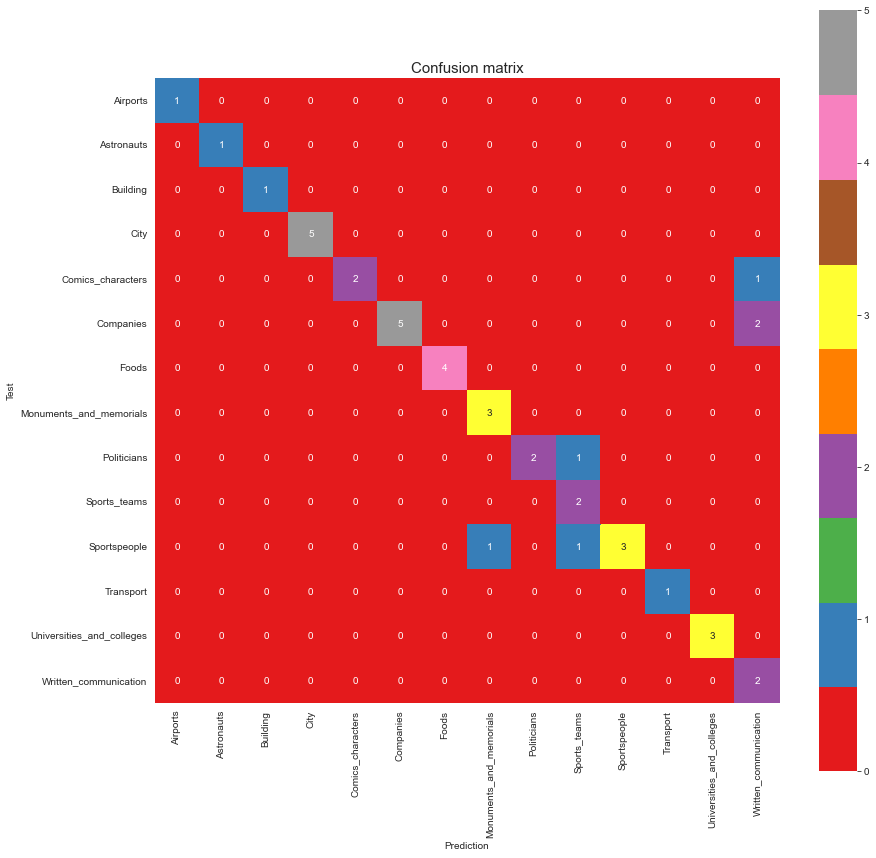

In [22]:
complete(df)

### We test text not preprocessed

Precision : 0.8511904761904762
Recall : 0.8914965986394557
F1 Score : 0.8392857142857143
Accuracy : 0.8536585365853658
Accuracy per categories : {'Airports': 1.0, 'Building': 0.975609756097561, 'Transport': 0.926829268292683, 'Sportspeople': 1.0, 'City': 0.975609756097561, 'Astronauts': 0.9512195121951219, 'Foods': 1.0, 'Universities_and_colleges': 1.0, 'Sports_teams': 1.0, 'Politicians': 0.975609756097561, 'Companies': 0.9512195121951219, 'Written_communication': 1.0, 'Comics_characters': 1.0, 'Monuments_and_memorials': 0.9512195121951219}


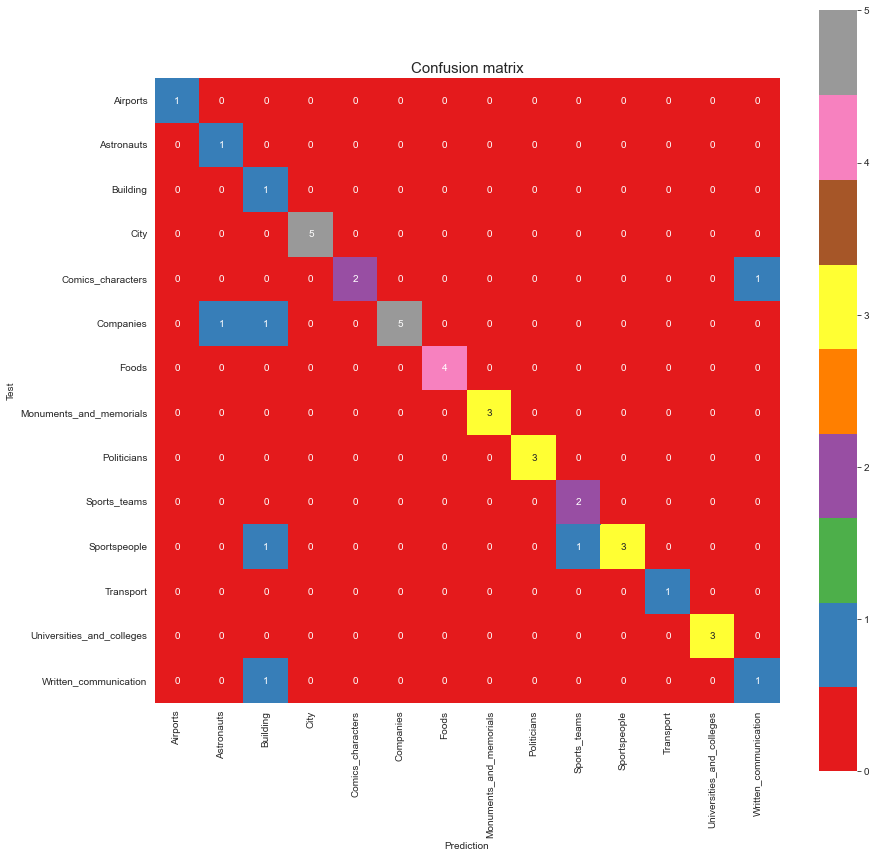

In [23]:
complete(df, x='text')

### We test text preprocessed only

Precision : 0.8964285714285715
Recall : 0.8931972789115646
F1 Score : 0.8626623376623377
Accuracy : 0.8292682926829268
Accuracy per categories : {'Airports': 1.0, 'Building': 1.0, 'Transport': 1.0, 'Sportspeople': 1.0, 'City': 0.975609756097561, 'Astronauts': 0.926829268292683, 'Foods': 1.0, 'Universities_and_colleges': 0.975609756097561, 'Sports_teams': 0.975609756097561, 'Politicians': 0.926829268292683, 'Companies': 0.9512195121951219, 'Written_communication': 1.0, 'Comics_characters': 1.0, 'Monuments_and_memorials': 0.926829268292683}


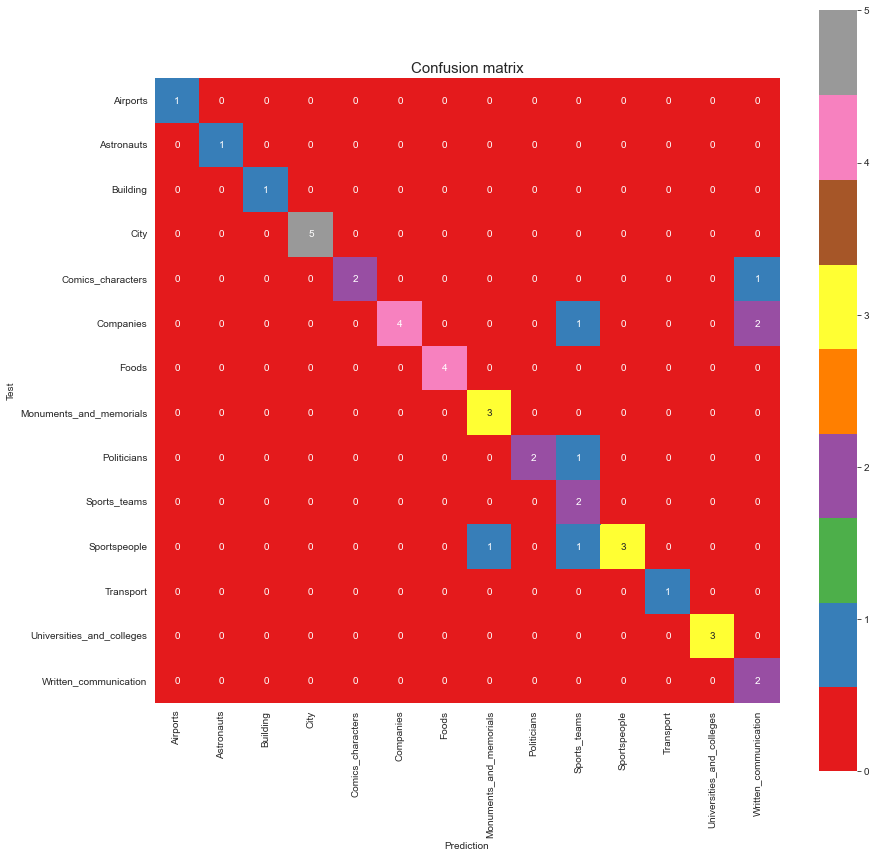

In [24]:
complete(df, x='processed_text_only')

### We test everything (text + description + text annotated + description annotated)

Precision : 0.7418831168831169
Recall : 0.585204081632653
F1 Score : 0.5736054421768707
Accuracy : 0.4878048780487805
Accuracy per categories : {'Airports': 1.0, 'Building': 0.975609756097561, 'Transport': 1.0, 'Sportspeople': 0.9024390243902439, 'City': 0.975609756097561, 'Astronauts': 0.8536585365853658, 'Foods': 0.926829268292683, 'Universities_and_colleges': 0.926829268292683, 'Sports_teams': 0.975609756097561, 'Politicians': 1.0, 'Companies': 0.9512195121951219, 'Written_communication': 1.0, 'Comics_characters': 0.5365853658536586, 'Monuments_and_memorials': 0.9512195121951219}


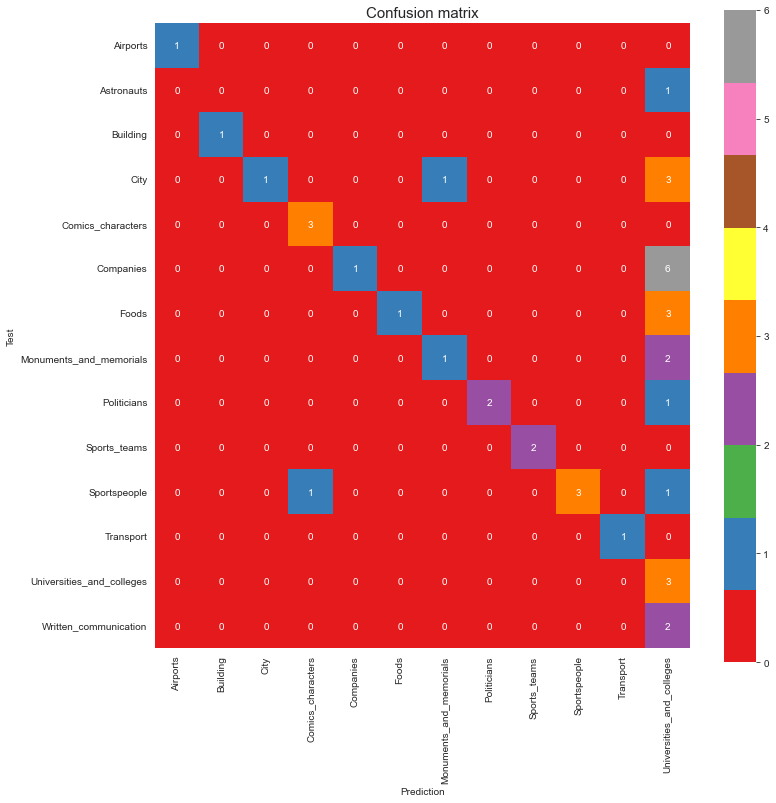

In [25]:
complete(df, x='all')

### We test everything annotated (text + description)

Precision : 0.7142857142857143
Recall : 0.6673469387755101
F1 Score : 0.6193609022556391
Accuracy : 0.6097560975609756
Accuracy per categories : {'Airports': 0.9512195121951219, 'Building': 0.975609756097561, 'Transport': 1.0, 'Sportspeople': 0.9512195121951219, 'City': 1.0, 'Astronauts': 0.8536585365853658, 'Foods': 0.7317073170731707, 'Universities_and_colleges': 0.9512195121951219, 'Sports_teams': 0.9024390243902439, 'Politicians': 1.0, 'Companies': 0.9512195121951219, 'Written_communication': 1.0, 'Comics_characters': 1.0, 'Monuments_and_memorials': 0.9512195121951219}


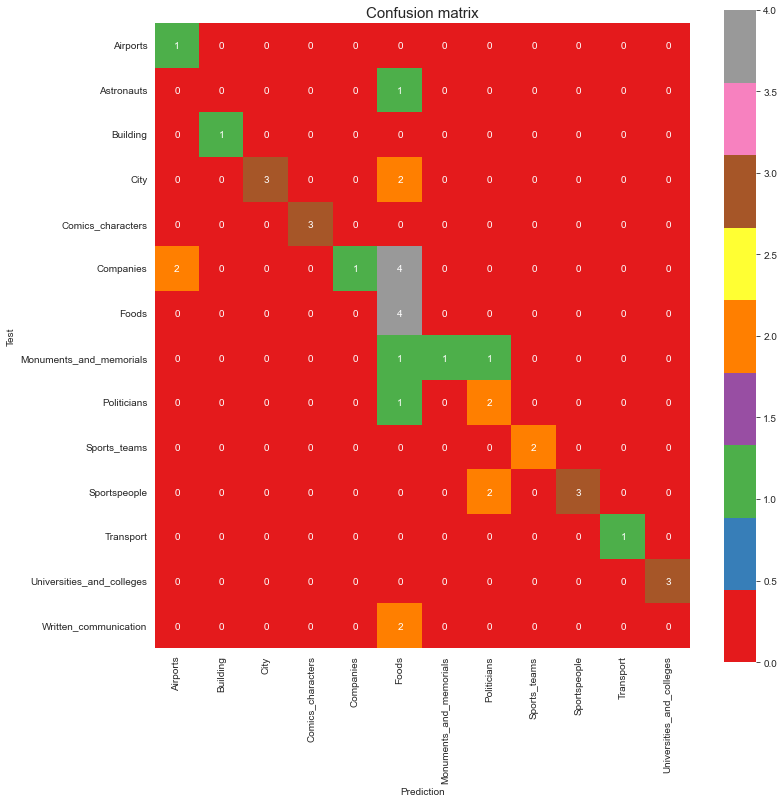

In [26]:
complete(df, x='annotated_all', max_iter=20)